In [8]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from unlearning.auditors.utils import (
    load_forget_set_indices,
)
from unlearning.unlearning_algos.base_nn import NAME_TO_ALGO
from importlib import reload 
from scipy import stats

CWD =Path.cwd()
BASE_DIR = CWD.parent.parent
BASE_DIR
config_file = BASE_DIR/ "configs" /"test_oracle_matching.yaml"

config_file.exists()
config_file


PosixPath('/n/home04/rrinberg/code/unlearning-with-trak/configs/test_oracle_matching.yaml')

In [9]:
def read_yaml(f):
    with open(f, "r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

from unlearning.auditors import eval_suite
reload(eval_suite)

config_dict = read_yaml(config_file)
forget_set_id = 5
retain_data_amount= 2.
mix_data = True
num_epochs = 5


config_dict["forget_set_id"] = forget_set_id
config_dict["unlearning_algo_kwargs"]["oracles_path"] = f"/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracles/CIFAR10/forget_set_{forget_set_id}"
config_dict["unlearning_algo_kwargs"]["forget_set_id"] = forget_set_id
config_dict["unlearning_algo_kwargs"]["retain_data_amount"] = retain_data_amount
config_dict["run_direct_eval"] = True
config_dict["only_direct_eval"] = True

config_dict["N_models_for_direct"] = 2
config_dict["unlearning_algo_kwargs"]["mix_data"] =  mix_data
config_dict["unlearning_algo_kwargs"]["num_epochs"] = num_epochs 
config_dict["unlearning_algo"] = "do_nothing"
config_dict


{'results_dir': './results/',
 'dataset': 'CIFAR10',
 'run_direct_eval': True,
 'use_submitit_for_direct_eval': False,
 'unlearning_algo_kwargs': {'dataset': 'CIFAR10',
  'oracles_path': '/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracles/CIFAR10/forget_set_5',
  'forget_set_id': 5,
  'retain_data_amount': 2.0,
  'mix_data': True,
  'num_epochs': 5},
 'reorder_logit_classes': True,
 'forget_set_id': 5,
 'only_direct_eval': True,
 'N_models_for_direct': 2,
 'unlearning_algo': 'do_nothing'}

In [10]:
#config_dict["only_direct_eval"] = True
from unlearning.auditors import direct
reload(eval_suite)
reload(direct)

#config_dict["only_ulira"]=True
config_dict["use_submitit_for_direct_eval"] = True
config_dict["slurm_partition"] = "seas_gpu"
config_dict["gres"] = "gpu:1"
config_dict["constraint"] = "a100|v100"
# delete "constraint"
#config_dict.pop("constraint")

results_dir, results = eval_suite.eval_suite(config_dict=config_dict,
                                             overwrite=True)


05/11/2024 16:07:04:INFO:Setting up eval suite..
05/11/2024 16:07:04:INFO:Loaded model.
05/11/2024 16:07:04:INFO:Loaded unlearning algo: do_nothing


{'results_dir': './results/',
 'dataset': 'CIFAR10',
 'run_direct_eval': True,
 'use_submitit_for_direct_eval': True,
 'unlearning_algo_kwargs': {'dataset': 'CIFAR10',
                            'oracles_path': '/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracles/CIFAR10/forget_set_5',
                            'forget_set_id': 5,
                            'retain_data_amount': 2.0,
                            'mix_data': True,
                            'num_epochs': 5},
 'reorder_logit_classes': True,
 'forget_set_id': 5,
 'only_direct_eval': True,
 'N_models_for_direct': 2,
 'unlearning_algo': 'do_nothing',
 'slurm_partition': 'seas_gpu',
 'gres': 'gpu:1',
 'constraint': 'a100|v100'}


KeyboardInterrupt: 

In [ ]:
p = Path(
    "/n/home04/rrinberg/code/unlearning-with-trak/notebooks/oracle_matching_eval/results/CIFAR10__5__do_nothing__dataset=CIFAR10__forget_set_id=5__retain_data_amount=2.0__mix_data=True__num_epochs=5/submitit_logs/"# 32223990_0_0_result.pkl"
)
p.exists()
print(list(p.glob("*")))

In [ ]:
from unlearning.auditors.ulira import load_all_ulira_margins

ds_name= "CIFAR10"
ulira_train_all_margins, ulira_val_all_margins = load_all_ulira_margins(
    ds_name)

import torch

a= torch.cat([
    torch.tensor(ulira_train_all_margins.T),
    torch.tensor(ulira_val_all_margins.T)
]).T
print(a.shape)
print(ulira_train_all_margins.shape)
print(ulira_val_all_margins.shape)

/tmp/ipykernel_1526318/3311134124.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ulira_train_all_margins.T),
/tmp/ipykernel_1526318/3311134124.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ulira_val_all_margins.T)


torch.Size([60000, 1950])
torch.Size([1950, 50000])
torch.Size([1950, 10000])


In [ ]:
import os
import shutil
import yaml
import numpy as np
import torch as ch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import logging
import pprint
from contextlib import redirect_stdout, redirect_stderr

from unlearning.auditors.utils import (
    model_factory,
    loader_factory,
    load_forget_set_indices,
    get_full_model_paths,
    get_oracle_paths,
    make_results_dir,
)
from unlearning.auditors.accuracies import eval_accuracy
from unlearning.auditors.logit_plots import compute_logits, plot_logits
from unlearning.auditors.basic import plot_margins
from unlearning.auditors.ulira import cheap_ulira_audit_precomputed
from unlearning.auditors.direct import (
    config_submitit,
    direct_audit_precomputed,
    get_u_margins,
    u_margin_job,
    plot_margins_direct,
    average_ulira
)
from unlearning.unlearning_algos.base_nn import NAME_TO_ALGO


def load_model(path, model_factory, ds_name):
    model = model_factory(ds_name)
    loaded_model = ch.load(path)
    first_key = list(loaded_model.keys())[0]
    if "model" in first_key:
        model.load_state_dict(loaded_model)

    else:
        # add ".model" to each key in k,vs
        loaded_model = {f"model.{k}": v for k, v in loaded_model.items()}
        model.load_state_dict(loaded_model)
    return model

# delete this after

config = config_dict

results = {}
results["params"] = {}
rng = np.random.RandomState(0)

ds_name = config["dataset"]

# for now, let's tie the model to the dataset, so we have fewer moving pieces
model = model_factory(ds_name)  # on cuda, in eval mode

forget_set_indices = load_forget_set_indices(ds_name, config["forget_set_id"])

results["params"]["forget_set_indices"] = forget_set_indices
unlearn_fn = NAME_TO_ALGO[config["unlearning_algo"]]

unlearning_kwargs = config["unlearning_algo_kwargs"]
if unlearning_kwargs is None:
    unlearning_kwargs = {}
with redirect_stdout(open("/dev/null", "w")):
    # no shuffling, no augmentation
    train_loader = loader_factory(ds_name, indexed=True)
    val_loader = loader_factory(ds_name, split="val", indexed=True)
    forget_loader = loader_factory(
        ds_name,
        indices=forget_set_indices,
        batch_size=50,
        indexed=True,
    )
    eval_set_inds = np.arange(len(train_loader.dataset) + len(val_loader.dataset))
    eval_loader = loader_factory(
        ds_name, split="train_and_val", indices=eval_set_inds, indexed=True
    )
splits = ["train", "val"]

f_ckpt_paths, f_logit_paths, f_margins_paths = get_full_model_paths(
    ds_name, splits=splits
)
(
    o_ckpt_0_path,  # we only need a single oracle checkpoint
    o_logit_paths,
    o_margins_paths,
) = get_oracle_paths(ds_name, config["forget_set_id"], splits=splits)

model = load_model(f_ckpt_paths[0], model_factory, ds_name)

_inds_to_plot = rng.choice(np.arange(len(forget_set_indices)), 20)
inds_to_plot = forget_set_indices[_inds_to_plot]


all_unlearned_margins = []

f_ckpt_paths = f_ckpt_paths[: config["N_models_for_direct"]]

for f_ckpt_path in tqdm(f_ckpt_paths, desc="unlearning models.."):
    _m = get_u_margins(
        model,
        f_ckpt_path,
        unlearn_fn,
        unlearning_kwargs,
        train_loader,
        eval_loader,
        forget_set_indices,
    )
    all_unlearned_margins.append(_m)
all_unlearned_margins = ch.stack(all_unlearned_margins)


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
unlearning models..: 100%|██████████| 10/10 [02:17<00:00, 13.72s/it]


In [ ]:
from unlearning.auditors import direct
# import (average_ulira)
reload(direct)


all_oracle_margins = ch.cat([ch.load(path) for path in o_margins_paths], dim=1)

all_oracle_margins = all_oracle_margins[:, eval_set_inds]


#direct_results = direct_audit_precomputed( all_unlearned_margins, all_oracle_margins )

ulira = direct.average_ulira(all_unlearned_margins, all_oracle_margins)


model counts: 10
updated
updated
updated
updated
updated
updated
updated
updated
updated
updated


(array([1.31666667e-02, 3.33333333e-03, 5.35000000e-02, 0.00000000e+00,
        6.86666667e-02, 2.75333333e-01, 2.82166667e-01, 0.00000000e+00,
        4.06000000e-01, 8.89783333e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

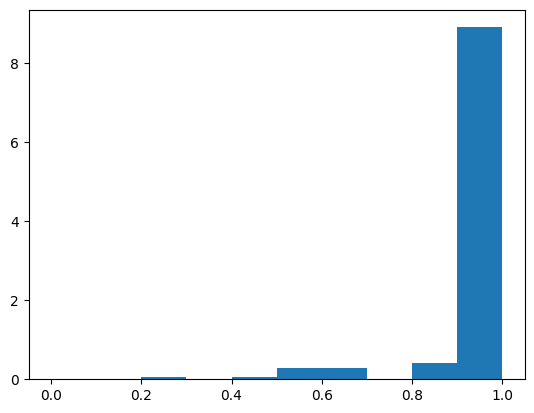

In [ ]:
plt.hist(ulira,density = True)

In [ ]:
from scipy.stats import norm

def gaussian_probability(mean, sigma, value):
    return norm.pdf(value, mean, sigma)


def single_ulira(
    all_unlearned_margins: ch.Tensor,  # T x n 
    all_oracle_margins: ch.Tensor,  # T x n
    hold_out_model: int,
    threshold=0.5,
):
    """
    Compute the ULIRA (Unlearning Likelihood Ratio) results for each sample. for a single unlearned model.

    Note: 
        1: (x,y) is likely a member of training (unlearned model)
        0: (x,y) is likely a member of the oracle (oracle model)

    Args:
        all_unlearned_margins (ch.Tensor): Tensor of shape T x n containing the margins of all unlearned models.
        all_oracle_margins (ch.Tensor): Tensor of shape T x n containing the margins of all oracle models.
        hold_out_model (int): Index of the hold-out model.
        threshold (float, optional): Threshold value for the likelihood ratio. Defaults to 0.5.

    Returns:
        np.ndarray: Array of ULIRA results for each sample, where 1 indicates the likelihood ratio is above the threshold, and 0 otherwise.
    """
    N = all_unlearned_margins.shape[1]
    ULIRA_results = np.zeros(N)

    for sample in range(N):
        oracle_arr = all_oracle_margins[:, sample].cpu().numpy()
        unlearned_arr = all_unlearned_margins[:, sample].cpu().numpy()

        #

        unlearned_model_margin = unlearned_arr[hold_out_model]
        other_unlearned_models = np.delete(unlearned_arr, hold_out_model)

        # fit gaussians
        oracle_mean, oracle_std = np.mean(oracle_arr), np.std(oracle_arr)
        unlearned_mean, unlearned_std = np.mean(
            other_unlearned_models), np.std(other_unlearned_models)

        # compute LIRA
        oracle_prob = gaussian_probability(oracle_mean, oracle_std,
                                           unlearned_model_margin)
        unlearned_prob = gaussian_probability(unlearned_mean, unlearned_std,
                                              unlearned_model_margin)

        likelihood_ratio = unlearned_prob / (unlearned_prob + oracle_prob)

        # save result
        ULIRA_results[sample] = (likelihood_ratio > threshold).astype(float)

    return ULIRA_results

def average_ulira(
    all_unlearned_margins: ch.Tensor,
    all_oracle_margins: ch.Tensor,
):
    """
    """
    results = []
    print(f"all_oracle_margins. shapes - {all_oracle_margins.shape}")
    print(f"all_unlearned_margins. shapes - {all_unlearned_margins.shape}")

    model_counts = all_unlearned_margins.shape[0]
    model_counts = 3
    print(f"model counts: {model_counts}")
    # compute ULIRA for each unlearned model
    for hold_out_unlearned_model in range(model_counts):
        print(hold_out_unlearned_model)
        single_ulira_results = single_ulira(all_unlearned_margins,
                                            all_oracle_margins,
                                            hold_out_unlearned_model,
                                            )
        results.append(single_ulira_results)
    # average over all unlearned models
    results = np.mean(np.stack(results), axis=0)
    return results

ulira = average_ulira(all_unlearned_margins, all_oracle_margins)


all_oracle_margins. shapes - torch.Size([250, 60000])
all_unlearned_margins. shapes - torch.Size([10, 60000])
model counts: 3
0
1
2


(array([12808.,     0.,     0., 17945.,     0.,     0., 20363.,     0.,
            0.,  8884.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

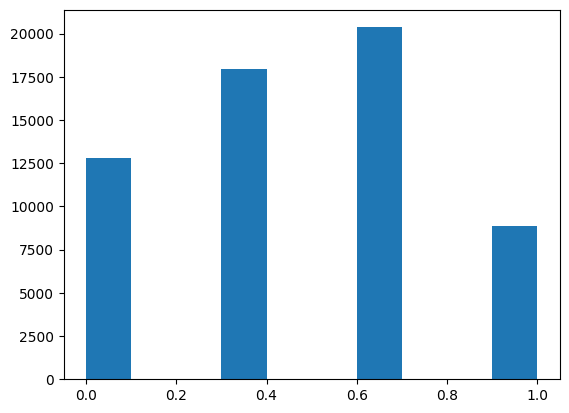

In [ ]:
plt.hist(ulira)

05/07/2024 15:58:51:INFO:Setting up eval suite..
05/07/2024 15:58:51:INFO:Loaded model.
05/07/2024 15:58:51:INFO:Loaded unlearning algo: do_nothing


{'results_dir': './results/',
 'dataset': 'CIFAR10',
 'forget_set_id': 5,
 'unlearning_algo': 'do_nothing',
 'run_direct_eval': True,
 'use_submitit_for_direct_eval': False,
 'unlearning_algo_kwargs': {'dataset': 'CIFAR10',
                            'forget_set_id': 5,
                            'oracles_path': '/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracles/CIFAR10/forget_set_5',
                            'retain_data_amount': 2.0,
                            'mix_data': True,
                            'num_epochs': 3},
 'reorder_logit_classes': True,
 'only_direct_eval': True,
 'N_models_for_direct': 10}


05/07/2024 15:58:54:INFO:Created loaders.
05/07/2024 15:58:54:INFO:Loaded paths of pretrained models.
05/07/2024 15:58:54:INFO:Loaded a pretrained model.
unlearning models..: 100%|██████████| 10/10 [02:13<00:00, 13.31s/it]
05/07/2024 16:01:08:INFO:Done computing margins for direct eval..
05/07/2024 16:01:08:INFO:Loading oracle margins..
05/07/2024 16:01:08:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Starting T-tests...
[[0.25423667 0.62946172 0.69965352 2.30909143]
 [0.20588987 0.0700006  0.90424233 2.79093912]
 [0.79381151 0.97193216 0.9473816  2.59079932]
 ...
 [0.04876001 0.20451568 1.00012626 2.74819361]
 [0.40891062 0.43661139 0.96238937 2.6581319 ]
 [0.14667897 0.34964385 0.82667689 2.71337367]]


IndexError: index 10 is out of bounds for axis 0 with size 10

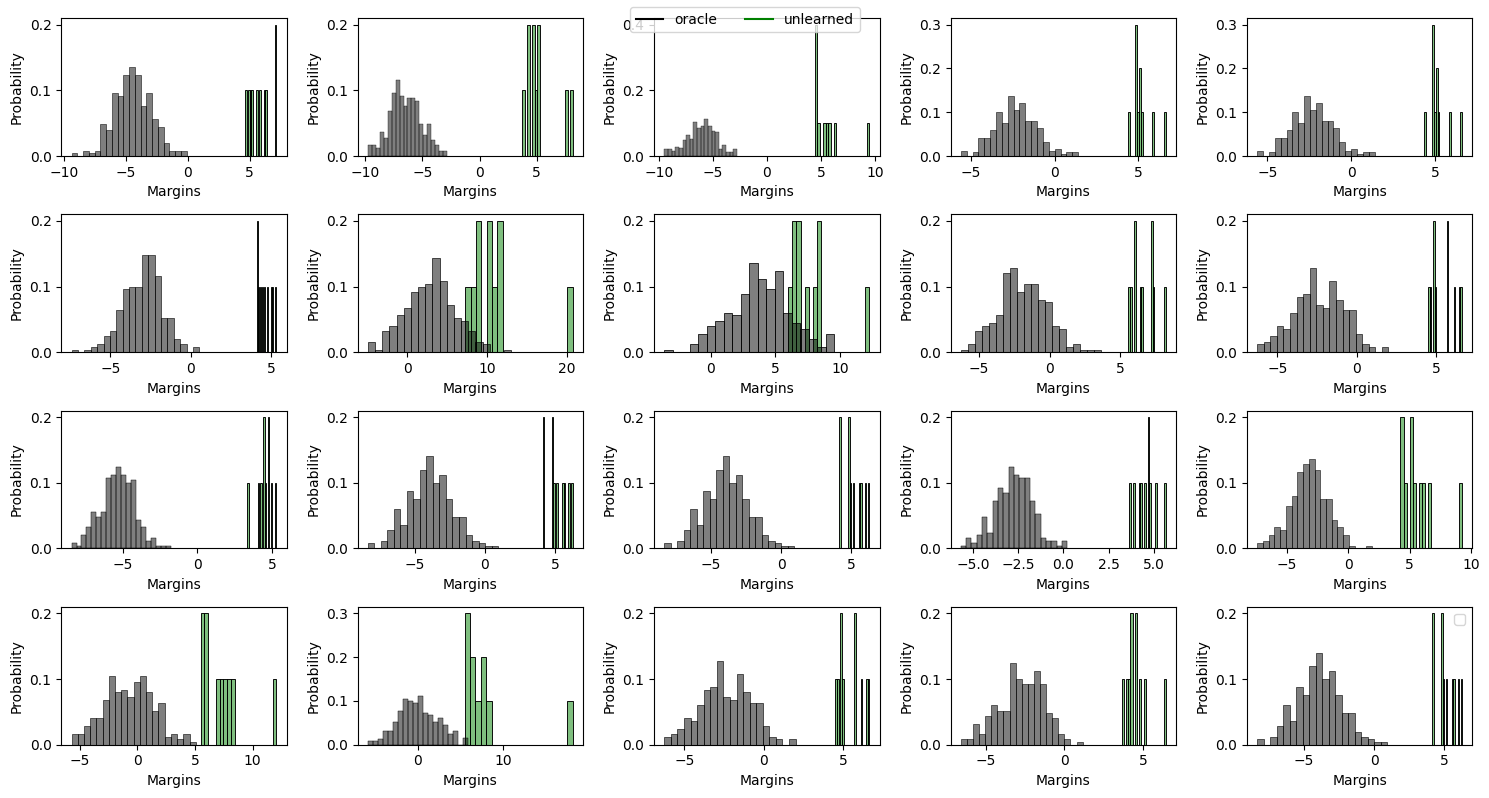

In [ ]:

results_dir, results = eval_suite.eval_suite(config_dict=config_dict, overwrite = True)

#np.savez("test_it_saves_results.npz", **results)

In [ ]:
p = Path(
    "/n/home04/rrinberg/code/unlearning-with-trak/notebooks/oracle_matching_eval/results/CIFAR10__5__do_nothing__dataset=CIFAR10__forget_set_id=5__retain_data_amount=2.0__mix_data=True__num_epochs=3/direct/direct_unlearned_margins.npy"
)
a = np.load(p)
a.shape
a[0].shape

(60000,)

In [ ]:
results.keys()#["direct_ulira"]

dict_keys(['params', 'direct_ulira'])

In [ ]:
FileExistsError: results/CIFAR10__5__do_nothing__dataset=CIFAR10__forget_set_id=5__retain_data_amount=2.0__mix_data=True__num_epochs=3 already exists. Set overwrite=True to overwrite.


In [ ]:
import os
import shutil
import yaml
import numpy as np
import torch as ch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import logging
import pprint
from contextlib import redirect_stdout, redirect_stderr

from unlearning.auditors.utils import (
    model_factory,
    loader_factory,
    load_forget_set_indices,
    get_full_model_paths,
    get_oracle_paths,
    make_results_dir,
)
from unlearning.auditors.accuracies import eval_accuracy
from unlearning.auditors.logit_plots import compute_logits, plot_logits
from unlearning.auditors.basic import plot_margins
from unlearning.auditors.ulira import cheap_ulira_audit_precomputed
from unlearning.auditors.direct import (
    config_submitit,
    direct_audit_precomputed,
    get_u_margins,
    u_margin_job,
    plot_margins_direct,
)
from unlearning.unlearning_algos.base_nn import NAME_TO_ALGO


def load_model(path, model_factory, ds_name):
    model = model_factory(ds_name)
    loaded_model = ch.load(path)
    first_key = list(loaded_model.keys())[0]
    if "model" in first_key:
        model.load_state_dict(loaded_model)

    else:
        # add ".model" to each key in k,vs
        loaded_model = {f"model.{k}": v for k, v in loaded_model.items()}
        model.load_state_dict(loaded_model)
    return model


In [ ]:
# 
from unlearning.unlearning_benchmarks.scrub import scrub_wrapper
forget_set_id =5
unlearn_name = "scrub"

#####

config = config_dict
results = {}
results["params"] = {}
ds_name = "CIFAR10"
# for now, let's tie the model to the dataset, so we have fewer moving pieces
model = model_factory(ds_name)  # on cuda, in eval mode


forget_set_indices = load_forget_set_indices(ds_name, forget_set_id)

results["params"]["forget_set_indices"] = forget_set_indices
unlearn_fn = NAME_TO_ALGO[unlearn_name]

unlearning_kwargs = config["unlearning_algo_kwargs"]
if unlearning_kwargs is None:
    unlearning_kwargs = {}

with redirect_stdout(open("/dev/null", "w")):
    # no shuffling, no augmentation
    train_loader = loader_factory(ds_name, indexed=True)
    val_loader = loader_factory(ds_name, split="val", indexed=True)
    forget_loader = loader_factory(
        ds_name,
        indices=forget_set_indices,
        batch_size=50,
        indexed=True,
    )
    eval_set_inds = np.arange(
        len(train_loader.dataset) + len(val_loader.dataset))
    eval_loader = loader_factory(ds_name,
                                    split="train_and_val",
                                    indices=eval_set_inds,
                                    indexed=True)
####### END OF SETUP ########

####### LOAD PRETRAINED MODELS ########
# f stands for "full model",
#   i.e. the model that was trained on the enitre dataset (retain + forget)
# o stands for "oracle model"
#   i.e. the model that was trained on the oracle dataset (retain only)

# inserted by Roy for some speed reason
splits = ["train", "val"]

f_ckpt_paths, f_logit_paths, f_margins_paths = get_full_model_paths(
    ds_name, splits=splits)
(
    o_ckpt_0_path,  # we only need a single oracle checkpoint
    o_logit_paths,
    o_margins_paths,
) = get_oracle_paths(ds_name, config["forget_set_id"], splits=splits)

# original model
model = load_model(f_ckpt_paths[0], model_factory, ds_name)

# oracle model
oracle_model = load_model(o_ckpt_0_path, model_factory, ds_name)

100%|██████████| 170498071/170498071 [00:01<00:00, 91014542.96it/s] 
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from unlearning.unlearning_benchmarks import scrub

from unlearning.unlearning_benchmarks.SCRUB.thirdparty.repdistiller.helper import loops
reload(loops)

reload(scrub)

# unlearning

unlearned_model = scrub.scrub_wrapper(
    model=model,
    train_dataloader=train_loader,
    forget_dataloader=None,
    forget_indices=forget_set_indices,
    **unlearning_kwargs,
)

In [ ]:
import torch

def l2_difference(model1, model2):
    l2_diff = 0.0
    # Ensure both models are in the same state (e.g., both in eval mode)
    model1.eval()
    model2.eval()

    with torch.no_grad():
        for (param1, param2) in zip(model1.parameters(), model2.parameters()):
            # Check if both parameters are on the same device and are of the same shape
            if param1.device != param2.device or param1.shape != param2.shape:
                raise ValueError("Models have parameters on different devices or with different shapes")
            
            # Compute the squared L2 norm of the difference between the parameters
            param_diff = param1 - param2
            l2_diff += torch.norm(param_diff, p=2).item()**2

    # Return the square root of the sum of squared differences
    return l2_diff**0.5

original_to_d = l2_difference(model, unlearned_model)
original_to_oracle = l2_difference(model, oracle_model)
unlearned_to_oracle = l2_difference(oracle_model, unlearned_model)
print(f"Original to Unlearned: {original_to_d}")
print(f"Original to Oracle: {original_to_oracle}")
print(f"Unlearned to Oracle: {unlearned_to_oracle}")


Original to Unlearned: 0.034105591600308044
Original to Oracle: 35.88708313018628
Unlearned to Oracle: 35.8764929755155


In [ ]:
d

0.034105591600308044

In [ ]:
# unlearned_model
for k in dir(unlearned_model.model):
    if "_" not in k:
        print(k)

append
apply
bfloat16
buffers
children
compile
cpu
cuda
double
eval
extend
float
forward
half
insert
ipu
modules
parameters
pop
to
train
training
type
xpu


In [ ]:

    logger.info(f"Loaded a pretrained model.")
    ####### END OF LOADING PRETRAINED MODELS ########
    if not config.get("only_direct_eval", True):


        ####### RUN UNLEARNING ALGO ONCE ########
        # run the unlearning algo on the model we just created once
        logger.info(f"Running unlearning algo..")

        unlearned_model = unlearn_fn(
            model=model,
            train_dataloader=train_loader,
            forget_dataloader=None,
            forget_indices=forget_set_indices,
            **unlearning_kwargs,
        )
        logger.info(f"Done running unlearning algo.")
        ####### END OF RUNNING UNLEARNING ALGO ########

        ####### SAVE & PLOT LOGITS ########
        LOGIT_EVAL_DIR = RESULTS_DIR / "logit_eval"
        LOGIT_EVAL_DIR.mkdir(parents=True, exist_ok=True)
        unlearned_logits = compute_logits(unlearned_model, eval_loader).numpy()
        np.save(LOGIT_EVAL_DIR / "unlearned_logits.npy", unlearned_logits)
        logger.info(
            f"Saved unlearned logits to {LOGIT_EVAL_DIR / 'unlearned_logits.npy'}"
        )

        fig = plot_logits(
            unlearned_logits=unlearned_logits,
            full_logit_paths=f_logit_paths,
            oracle_logit_paths=o_logit_paths,
            n_full_logits_to_plot=20,
            n_oracle_logits_to_plot=20,
            inds_to_plot=np.random.choice(forget_set_indices, 20),
            reorder_classes=config.get("reorder_logit_classes",
                                       False),  # keep for Roy
        )

        fig.savefig(LOGIT_EVAL_DIR / "logits_figure.png")
        logger.info(
            f"Saved logit figure to {LOGIT_EVAL_DIR / 'logits_figure.png'}")
        ####### END OF SAVING & PLOTTING LOGITS ########

        ####### EVALUATE ACCURACIES ########
        # eval the unlearned model accuracy on train/val/forget set
        train_acc, val_acc, forget_acc = eval_accuracy(
            unlearned_model,
            train_loader,
            val_loader,
            forget_loader,
        )
        oracle_model = load_model(o_ckpt_0_path, model_factory, ds_name)

        oracle_model.cuda().eval()  # can't be too sure
        oracle_train_acc, oracle_val_acc, oracle_forget_acc = eval_accuracy(
            oracle_model, train_loader, val_loader, forget_loader)

        print("=" * 20)
        print(f"Train acc:  {train_acc:.2f} (oracle: {oracle_train_acc:.2f})")
        print(f"Val acc:    {val_acc:.2f} (oracle: {oracle_val_acc:.2f})")
        print(
            f"Forget acc: {forget_acc:.2f} (oracle: {oracle_forget_acc:.2f})")
        print("=" * 20)
        # save csv with the accuracies
        # columns are forget_set_id, unlearning_algo, train_acc, val_acc, forget_acc
        # and there are two rows, one with the unlearned model, one with the oracle
        evaluations = {
            "forget_set_id":
            [config["forget_set_id"], config["forget_set_id"]],
            "unlearning_algo": [config["unlearning_algo"], "oracle"],
            "train_acc": [train_acc, oracle_train_acc],
            "val_acc": [val_acc, oracle_val_acc],
            "forget_acc": [forget_acc, oracle_forget_acc],
        }
        df = pd.DataFrame(evaluations)
        df.to_csv(RESULTS_DIR / "accuracies.csv")
        logger.info(f"Saved accuracies to {RESULTS_DIR / 'accuracies.csv'}")
        results.update(evaluations)

    f_ckpt_paths = f_ckpt_paths[:config["N_models_for_direct"]]
    for f_ckpt_path in tqdm(f_ckpt_paths, desc="unlearning models.."):
        _m = get_u_margins(
            model,
            f_ckpt_path,
            unlearn_fn,
            unlearning_kwargs,
            train_loader,
            eval_loader,
            forget_set_indices,
        )
        all_unlearned_margins.append(_m)
    all_unlearned_margins = ch.stack(all_unlearned_margins)

    logger.info(f"Done computing margins for direct eval..")
    if config.get("save_unlearned_margins", True):
        np.save(
            DIRECT_DIR / "direct_unlearned_margins.npy",
            all_unlearned_margins.numpy(),
        )

    logger.info("Loading oracle margins..")
    assert len(o_margins_paths) == 2
    assert o_margins_paths[0].stem.startswith("train")
    assert o_margins_paths[1].stem.startswith("val")
    all_oracle_margins = ch.cat(
        [ch.load(path) for path in o_margins_paths], dim=1)
    all_oracle_margins = all_oracle_margins[:, eval_set_inds]

    direct_results = direct_audit_precomputed(all_unlearned_margins,
                                                all_oracle_margins)
    print(direct_results)
    np.save(DIRECT_DIR / "ks_p_ce.npy", direct_results)

    direct_ulira_results = {
        "all_unlearned_margins": all_unlearned_margins,
        "direct_results": direct_results
    }
    results["direct_ulira"] = direct_ulira_results

    return results 

In [ ]:
results_dir, results = eval_suite.eval_suite(config_dict=config_dict)

#np.savez("test_it_saves_results.npz", **results)


05/01/2024 00:33:57:INFO:Setting up eval suite..


{'results_dir': './results/',
 'dataset': 'CIFAR10',
 'forget_set_id': 5,
 'unlearning_algo': 'scrub',
 'run_direct_eval': True,
 'use_submitit_for_direct_eval': False,
 'unlearning_algo_kwargs': {'dataset': 'CIFAR10',
                            'forget_set_id': 5,
                            'oracles_path': '/n/home04/rrinberg/data_dir__holylabs/unlearning/precomputed_models/oracles/CIFAR10/forget_set_5',
                            'retain_data_amount': 2.0,
                            'mix_data': True,
                            'num_epochs': 1},
 'reorder_logit_classes': True,
 'N_models_for_direct': 20}


05/01/2024 00:33:59:INFO:Loaded model.
05/01/2024 00:33:59:INFO:Loaded unlearning algo: scrub
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
05/01/2024 00:34:14:INFO:Created loaders.
05/01/2024 00:34:14:INFO:Loaded paths of pretrained models.
05/01/2024 00:34:14:INFO:Loaded a pretrained model.
unlearning models..:   0%|          | 0/20 [00:00<?, ?it/s]

No augmentation
Files already downloaded and verified
No augmentation
Files already downloaded and verified
total epochs : 1
Epoch 1 ...


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 100.000 


unlearning models..:   5%|▌         | 1/20 [01:24<26:44, 84.42s/it]

No augmentation
Files already downloaded and verified
No augmentation
Files already downloaded and verified
total epochs : 1
Epoch 1 ...
 * Acc@1 99.998 


unlearning models..:  10%|█         | 2/20 [02:40<23:46, 79.27s/it]

No augmentation
Files already downloaded and verified
No augmentation
Files already downloaded and verified
total epochs : 1
Epoch 1 ...
 * Acc@1 99.998 


unlearning models..:  10%|█         | 2/20 [03:28<31:17, 104.33s/it]


[ 4459 38698 32731 21941 21648 42929  4294 34869 10072  4705 26323 48779
 36788 38058 35873 39302 25661  6400 41986 22517 25018 18535  9123 46336
 39078 32196 20118 41138 27269 22167]
forget_margins- (100,)
val_margins- (10000,)


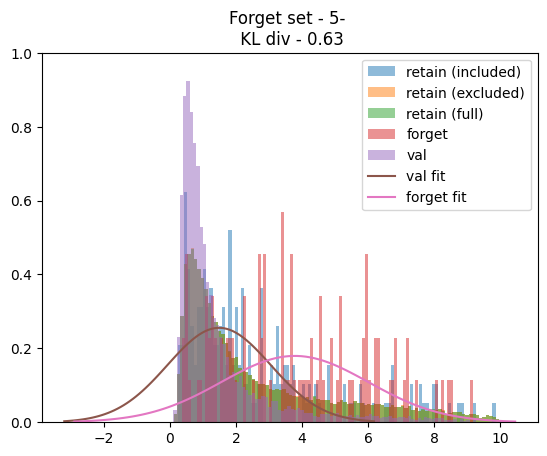

In [ ]:
def generate_cross_entropy(results,
                           forget_set_id,
                           retain_data_amount=2.,
                           dataset="CIFAR10",
                           title_str="",
                           save_path=None):
    forget_set_inds = load_forget_set_indices(dataset, forget_set_id)
    val_count = 10_000
    unlearned_margins = results["direct_ulira"]["all_unlearned_margins"]
    direct_results = results["direct_ulira"]["direct_results"]
    cross_entropies = direct_results[:, 2]


    train_inds = np.arange(50_000)
    retain_inds = np.setdiff1d(train_inds, forget_set_inds)

    retain_margins = cross_entropies[retain_inds]
    forget_margins = cross_entropies[forget_set_inds]
    val_margins = cross_entropies[-val_count:]
    ###
    num_retain_samples = int(retain_data_amount * len(forget_set_inds))
    rng = np.random.default_rng(seed=42)
    randomly_selected_indices = rng.choice(retain_inds, num_retain_samples)
    included_retain_pts = cross_entropies[randomly_selected_indices]
    excluded_retain_pts = cross_entropies[np.setdiff1d(
        retain_inds, randomly_selected_indices)]
    plt.figure()
    plt.hist(included_retain_pts,
                 bins=100,
                 alpha=0.5,
                 label="retain (included)",
                 density=True)
    plt.hist(excluded_retain_pts,
             bins=100,
             alpha=0.5,
             label="retain (excluded)",
             density=True)
    print(randomly_selected_indices[:30])

    plt.hist(retain_margins,
             bins=100,
             alpha=0.5,
             label="retain (full)",
             density=True)
    plt.hist(forget_margins, bins=100, alpha=0.5, label="forget", density=True)
    plt.hist(val_margins, bins=100, alpha=0.5, label="val", density=True)
    kl_div = 0

    if True:
        print(f"forget_margins- {forget_margins.shape}")

        print(f"val_margins- {val_margins.shape}")
        mu_val, sigma_val = np.mean(np.array(val_margins)), np.std(
            np.array(val_margins))
        x = np.linspace(mu_val - 3 * sigma_val, mu_val + 3 * sigma_val, 100)
        plt.plot(x, stats.norm.pdf(x, mu_val, sigma_val), label='val fit')

        mu_forget, sigma_forget = np.mean(np.array(forget_margins)), np.std(
            np.array(forget_margins))
        x = np.linspace(mu_forget - 3 * sigma_forget,
                        mu_forget + 3 * sigma_forget, 100)
        plt.plot(x,
                 stats.norm.pdf(x, mu_forget, sigma_forget),
                 label='forget fit')

        kl_div = kl_divergence_gaussians(mu_val, sigma_val, mu_forget,
                                         sigma_forget)
    plt.ylim(0,1    )
    plt.title(
        f"Forget set - {forget_set_id}- {title_str}\n KL div - {kl_div:.2f}")
    plt.legend()

    plt.show()

generate_cross_entropy(results, forget_set_id, retain_data_amount=retain_data_amount, dataset = "CIFAR10")